<a href="https://colab.research.google.com/github/AlejandroVillazonG/Tareas_INF395/blob/main/T1/T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<H1 align='center'> TAREA 1</H1>

<H3 align='center'> INF395 2023-2 </H3>
<hr style="height:2px;border:none"/>

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [1]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 9.5 MB/s eta 0:00:00


## Integrantes:
* Joaquín Aguirre (201910031-9)
* Alejandro Villazón (201910009-2)
* Dominique Yessouroun (201910005-K)

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
from sklearn.decomposition import PCA

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

import warnings
warnings.filterwarnings("ignore")

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [3]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [4]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [5]:
def plot_cm(y_pred, y_test, LABELS, grados = 0):
  "Función para graficar matriz de confusión"
  ConfusionMatrixDisplay.from_predictions(
      np.argmax(y_test, axis=1),
      np.argmax(y_pred, axis=1),
      cmap=plt.cm.Blues,
      display_labels = LABELS
  )
  plt.xticks(rotation=grados)
  plt.title('Confusion Matrix')
  plt.show()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [6]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Exploración de los Datos

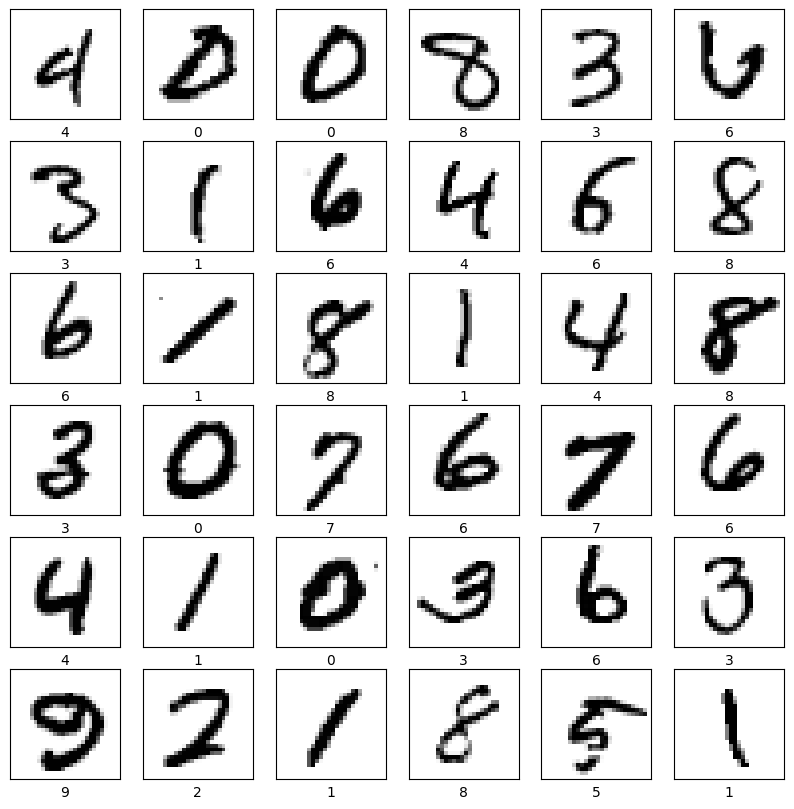

In [7]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [8]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('Cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

Cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [9]:
# convertimos los vectores de clases a matrices binarias
print('Antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespués:\n',y_train)

Antes:
 [5 0 4 ... 5 6 8]

Después:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [10]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

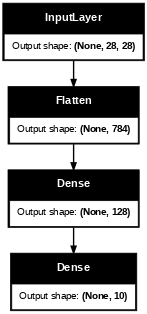

In [11]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [12]:
# Definimos algunos hiperparámetros
batch_size = 128        # Cantidad de imágenes por batch
epochs = 20             # Cantidad de epochs
validation_split = 0.2  # Porcentaje de data destinada a validación

In [13]:
# Compilamos nuestro modelo agregando la función de pérdida, el optimizador y las métricas
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [14]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2)

Epoch 1/20
375/375 - 15s - 40ms/step - accuracy: 0.6837 - loss: 4.8376 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 - 10s - 26ms/step - accuracy: 0.8059 - loss: 0.8962 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 - 1s - 3ms/step - accuracy: 0.8438 - loss: 0.6635 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 - 1s - 3ms/step - accuracy: 0.8666 - loss: 0.5376 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 - 1s - 3ms/step - accuracy: 0.8821 - loss: 0.4596 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 - 1s - 3ms/step - accuracy: 0.8935 - loss: 0.4059 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 - 1s - 3ms/step - accuracy: 0.9023 - loss: 0.3657 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 - 1s - 3ms/step - accuracy: 0.9091 - loss: 0.3342 - val_accuracy: 0.9021 - val_loss: 0.4528
Epoch 9/20
375/375 - 1s - 3ms/step - accuracy: 0.9139 - loss: 0.3098 - val_accuracy: 0.9072 - val_loss: 0.43

In [15]:
print(f'Primera epoch:\nAccuracy: {history.history["accuracy"][0]}\nVal_Accuracy: {history.history["val_accuracy"][0]}')

Primera epoch:
Accuracy: 0.6836875081062317
Val_Accuracy: 0.7898333072662354


In [16]:
print(f'Primera epoch:\nLoss: {history.history["loss"][0]}\nVal_Loss: {history.history["val_loss"][0]}')

Primera epoch:
Loss: 4.8376007080078125
Val_Loss: 1.0556691884994507


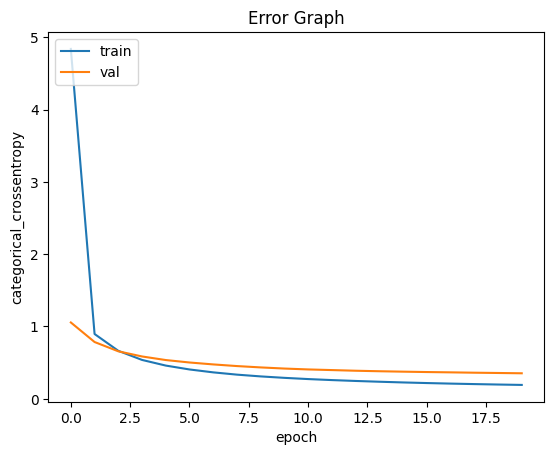

In [17]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36799514293670654
Test accuracy: 0.9212999939918518


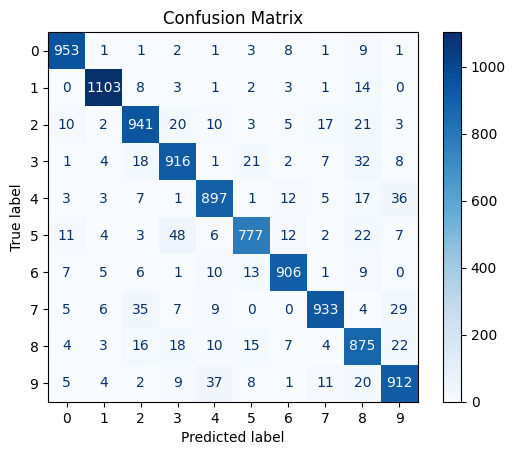

In [19]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test, verbose = 0)

plot_cm(y_pred, y_test, np.arange(10))

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: **'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.**

In [20]:
# Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [21]:
# Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

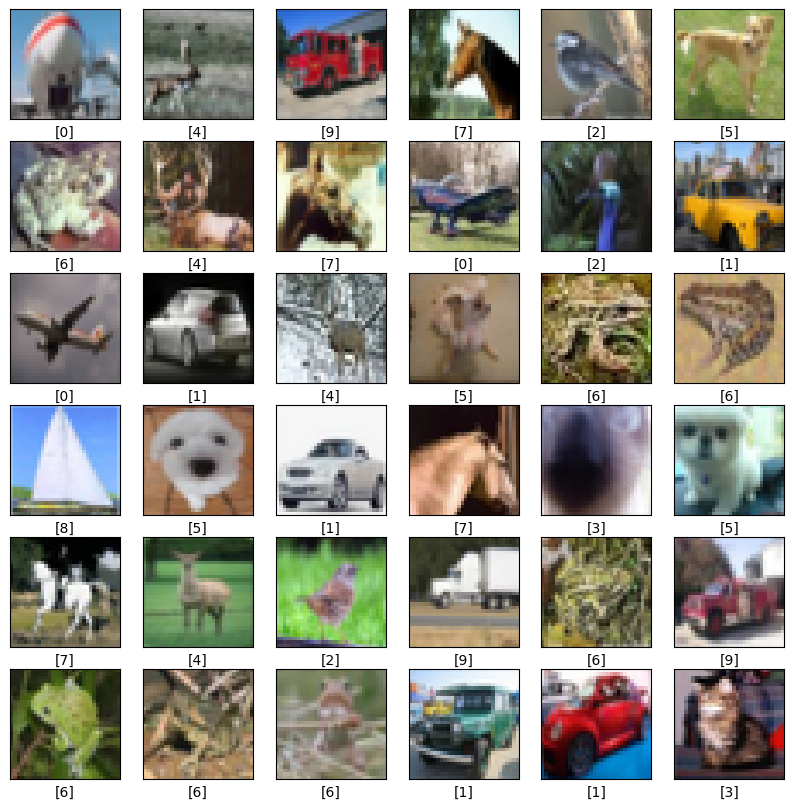

In [22]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [23]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


Notamos que la tercera dimensión en los datos se debe a que estamos trabajando los colores en formato RGB

In [24]:
print(f'Valor máximo: {x_train.max()}')
print(f'Valor mínimo: {x_train.min()}')

Valor máximo: 255
Valor mínimo: 0


In [25]:
# Convertimos los vectores de clases a matrices binarias
print('Antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespués:\n',y_train)

Antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Después:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [26]:
# Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

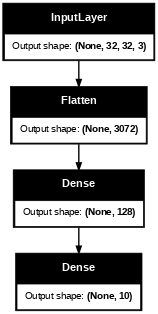

In [27]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [28]:
# Definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [29]:
# Compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [30]:
# Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2)

Epoch 1/20
313/313 - 5s - 17ms/step - accuracy: 0.0989 - loss: 125.0115 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.1010 - loss: 2.3037 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 - 3s - 10ms/step - accuracy: 0.1008 - loss: 2.3023 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 - 5s - 15ms/step - accuracy: 0.1014 - loss: 2.3020 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 - 3s - 8ms/step - accuracy: 0.1014 - loss: 2.3019 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 - 3s - 8ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 - 3s - 10ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 - 3s - 8ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3129
Epoch 9/20
313/313 - 2s - 7ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.

In [31]:
print(f'Primera epoch:\nAccuracy: {history.history["accuracy"][0]}\nVal_Accuracy: {history.history["val_accuracy"][0]}')

Primera epoch:
Accuracy: 0.09892500191926956
Val_Accuracy: 0.09529999643564224


In [32]:
print(f'Primera epoch:\nLoss: {history.history["loss"][0]}\nVal_Loss: {history.history["val_loss"][0]}')

Primera epoch:
Loss: 125.0114974975586
Val_Loss: 2.3143861293792725


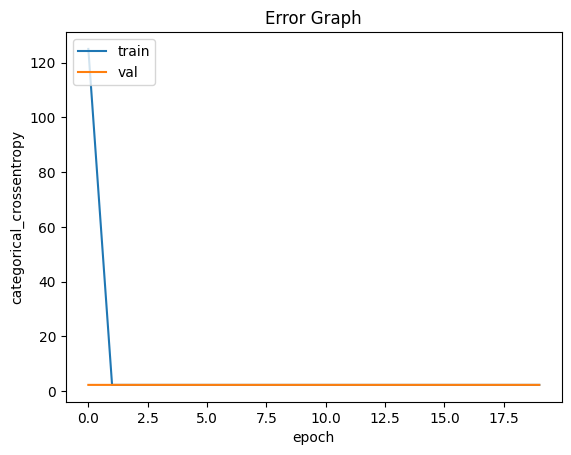

In [33]:
plot_losses(history, loss)

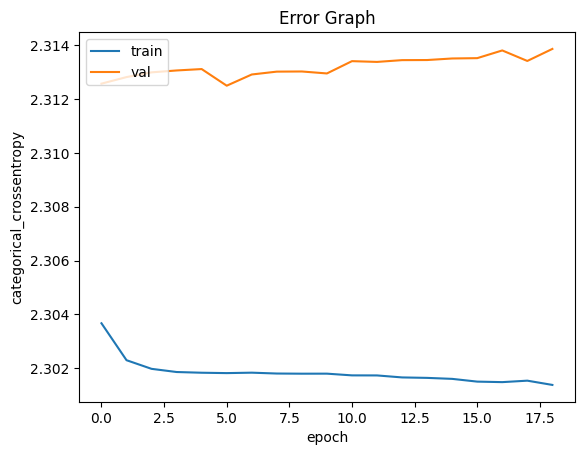

In [34]:
# Realizamos el mismo gráfico pero quitando la información de la primera epoch
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Error Graph')
plt.ylabel(loss.name)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


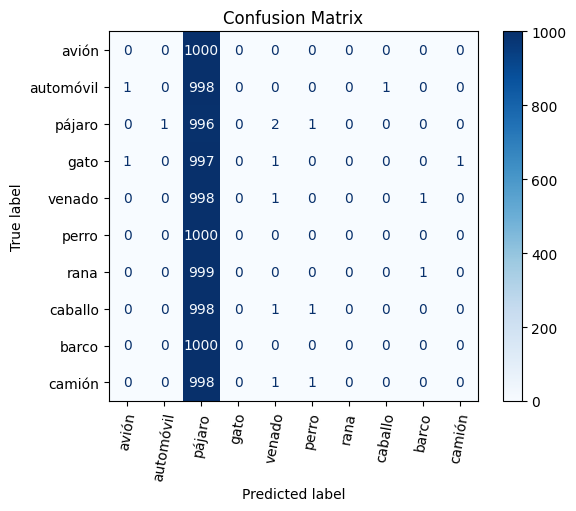

In [36]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test, verbose = 0)

LABELS_Cifar10 = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

plot_cm(y_pred, y_test, LABELS_Cifar10, 80)

In [37]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=LABELS_Cifar10))

              precision    recall  f1-score   support

       avión       0.00      0.00      0.00      1000
   automóvil       0.00      0.00      0.00      1000
      pájaro       0.10      1.00      0.18      1000
        gato       0.00      0.00      0.00      1000
      venado       0.17      0.00      0.00      1000
       perro       0.00      0.00      0.00      1000
        rana       0.00      0.00      0.00      1000
     caballo       0.00      0.00      0.00      1000
       barco       0.00      0.00      0.00      1000
      camión       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



Podemos observar cómo este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [38]:
# Es una práctica común en modelos de machine learning escalar nuestros datos.
# Así nos aseguramos de que todos tengan el mismo rango.
# Con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.
# Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [39]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

**`Respuesta:`** Durante el entrenamiento de la red neuronal, en cada epoch se aplica una probabilidad de "apagar" (dropout) ciertas neuronas de la capa anterior, lo que evita que la red se vuelva demasiado dependiente de características particulares de los datos.

En otras palabras, las capas Dropout introducen incertidumbre en la red al forzarla a aprender características relevantes de los datos desde múltiples subconjuntos de neuronas activas, en lugar de depender en exceso de neuronas individuales. Esto puede considerarse como un tipo de regularización, ya que la red aprende a ser más robusta y a generalizar mejor al estar expuesta a diferentes configuraciones de neuronas activas.

Observaciones:
1. La retropropagación se realiza normalmente, pero solo para las neuronas activas en esa iteración. Las neuronas apagadas no contribuyen al cálculo de los gradientes durante ese paso.
2. Al evaluar el modelo en el conjunto de validación o en datos de prueba, no se aplica dropout. Todas las neuronas están activas.

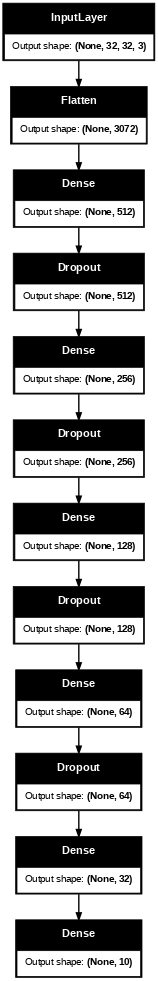

In [40]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [41]:
# Agregamos Callbacks
# Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado.
# lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False, así que siempre asegurarse de ponerlo en True
    )
]

In [42]:
# Cambiamos el Optimizador a Adam
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [43]:
# agregamos más epochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [44]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 - 17s - 55ms/step - accuracy: 0.2039 - loss: 2.1098 - val_accuracy: 0.2858 - val_loss: 1.9321
Epoch 2/200
313/313 - 8s - 25ms/step - accuracy: 0.2995 - loss: 1.9011 - val_accuracy: 0.3444 - val_loss: 1.8212
Epoch 3/200
313/313 - 3s - 8ms/step - accuracy: 0.3350 - loss: 1.8264 - val_accuracy: 0.3496 - val_loss: 1.7789
Epoch 4/200
313/313 - 5s - 17ms/step - accuracy: 0.3570 - loss: 1.7788 - val_accuracy: 0.3725 - val_loss: 1.7408
Epoch 5/200
313/313 - 3s - 10ms/step - accuracy: 0.3723 - loss: 1.7416 - val_accuracy: 0.3855 - val_loss: 1.7073
Epoch 6/200
313/313 - 3s - 9ms/step - accuracy: 0.3871 - loss: 1.7006 - val_accuracy: 0.3929 - val_loss: 1.7024
Epoch 7/200
313/313 - 3s - 9ms/step - accuracy: 0.3962 - loss: 1.6761 - val_accuracy: 0.4075 - val_loss: 1.6434
Epoch 8/200
313/313 - 5s - 16ms/step - accuracy: 0.4085 - loss: 1.6465 - val_accuracy: 0.4142 - val_loss: 1.6349
Epoch 9/200
313/313 - 3s - 10ms/step - accuracy: 0.4159 - loss: 1.6238 - val_accuracy: 0.4231 - va

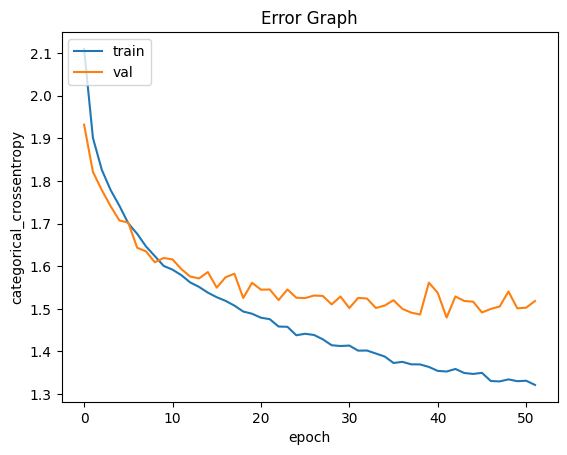

In [45]:
plot_losses(history, loss)

In [46]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4516677856445312
Test accuracy: 0.48649999499320984


Aún estamos con un accuracy del 0.5, lo que es equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

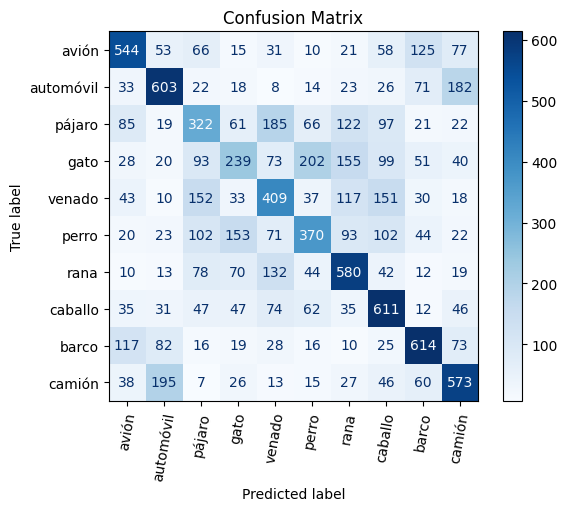

In [47]:
y_pred = model.predict(x_test, verbose = 0)

plot_cm(y_pred, y_test, LABELS_Cifar10, 80)

In [48]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=LABELS_Cifar10))

              precision    recall  f1-score   support

       avión       0.57      0.54      0.56      1000
   automóvil       0.57      0.60      0.59      1000
      pájaro       0.36      0.32      0.34      1000
        gato       0.35      0.24      0.28      1000
      venado       0.40      0.41      0.40      1000
       perro       0.44      0.37      0.40      1000
        rana       0.49      0.58      0.53      1000
     caballo       0.49      0.61      0.54      1000
       barco       0.59      0.61      0.60      1000
      camión       0.53      0.57      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



### 1.2.3 Último Modelo: Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y cómo lo hacen? [3pts]**

**`Respuesta:`** Las Skip Connections, resuelven el problema de la degradación del rendimiento que puede ocurrir en redes neuronales profundas debido a la "desaparición del gradiente". Este problema se manifiesta cuando se agregan capas adicionales a una red neuronal profunda y, en lugar de mejorar el rendimiento, la red comienza a converger más lentamente o incluso empeora su rendimiento en conjuntos de datos de entrenamiento.

La idea de las skip connections es agrupar capas de la red en bloques. Por cada bloque, las capas pasarán sus datos normalmente, pero entre bloques se tendrá un nuevo tipo de conexión, la cual funciona combinando (ya sea mediante suma o concatenación) la entrada al bloque con la salida de este, dando dos caminos diferentes para que los datos sigan, uno que pasa por el bloque y otro alrededor de este.

Las skip connections abordan este problema al permitir que las capas de una red neuronal aprendan residuos o diferencias entre las entradas y las salidas. En lugar de forzar una capa a aprender a mapear directamente las entradas a las salidas, las skip connections permiten que las capas aprendan a mapear las entradas a las diferencias entre las entradas y las salidas esperadas. Esto permite que las capas aprendan cambios más sutiles y, por lo tanto, facilita el entrenamiento profundo.

*Beneficios:* La adición de la entrada original a la salida de la capa intermedia tiene un efecto de "short-circuiting" (cortocircuito). Si las capas intermedias no logran aprender ninguna mejora útil, la suma simplemente se aproxima a la entrada original, evitando la degradación del rendimiento.


In [49]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

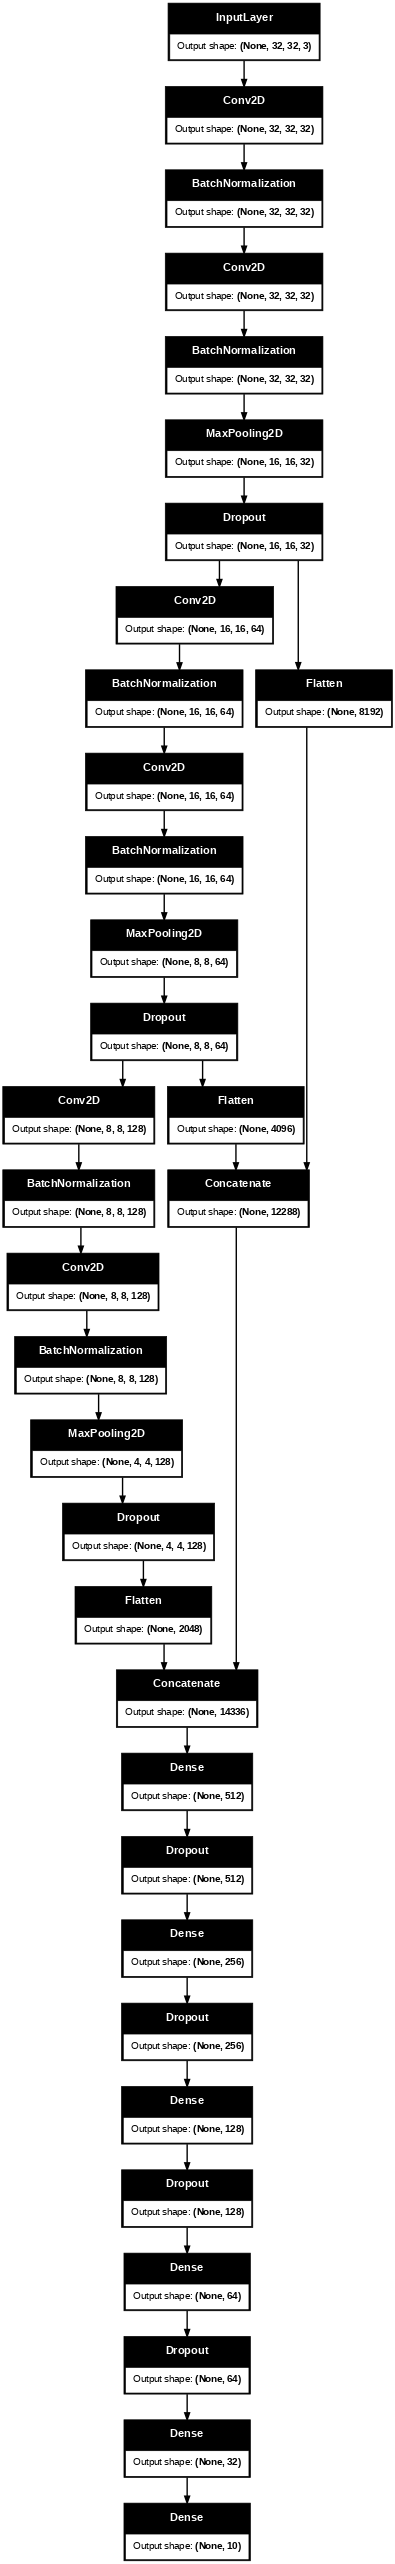

In [50]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [51]:
# Cambiamos el Optimizador a AdamW
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.AdamW(learning_rate=1e-3)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [52]:
# Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [53]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [54]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 - 41s - 130ms/step - accuracy: 0.3134 - loss: 2.0217 - val_accuracy: 0.3428 - val_loss: 1.7430
Epoch 2/200
313/313 - 7s - 21ms/step - accuracy: 0.5084 - loss: 1.3739 - val_accuracy: 0.5566 - val_loss: 1.2765
Epoch 3/200
313/313 - 7s - 21ms/step - accuracy: 0.6063 - loss: 1.1251 - val_accuracy: 0.6655 - val_loss: 0.9732
Epoch 4/200
313/313 - 6s - 20ms/step - accuracy: 0.6837 - loss: 0.9272 - val_accuracy: 0.6832 - val_loss: 0.9278
Epoch 5/200
313/313 - 6s - 20ms/step - accuracy: 0.7354 - loss: 0.7724 - val_accuracy: 0.7099 - val_loss: 0.8828
Epoch 6/200
313/313 - 6s - 20ms/step - accuracy: 0.7770 - loss: 0.6611 - val_accuracy: 0.7431 - val_loss: 0.7843
Epoch 7/200
313/313 - 6s - 21ms/step - accuracy: 0.8127 - loss: 0.5576 - val_accuracy: 0.7254 - val_loss: 0.8808
Epoch 8/200
313/313 - 6s - 20ms/step - accuracy: 0.8404 - loss: 0.4747 - val_accuracy: 0.7708 - val_loss: 0.7692
Epoch 9/200
313/313 - 11s - 34ms/step - accuracy: 0.8650 - loss: 0.4022 - val_accuracy: 0.7460

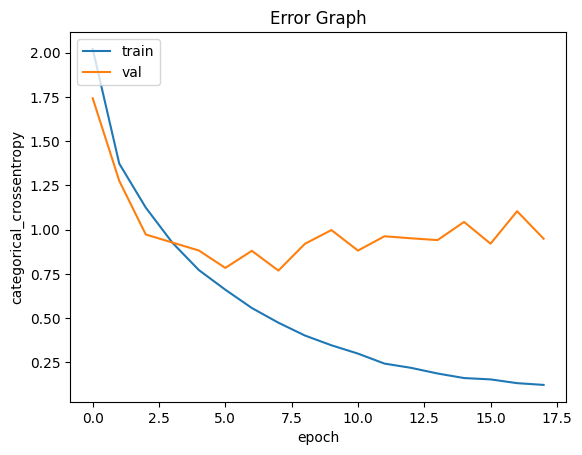

In [55]:
plot_losses(history, loss)

In [56]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7977376580238342
Test accuracy: 0.754800021648407


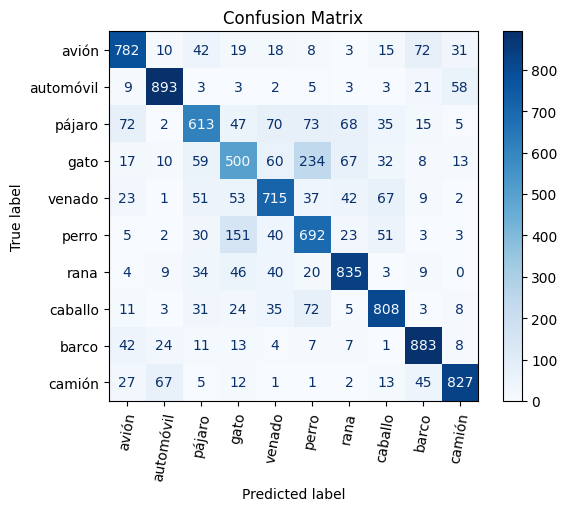

In [57]:
y_pred = model.predict(x_test, verbose = 0)

plot_cm(y_pred, y_test, LABELS_Cifar10, 80)

In [58]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=LABELS_Cifar10))

              precision    recall  f1-score   support

       avión       0.79      0.78      0.79      1000
   automóvil       0.87      0.89      0.88      1000
      pájaro       0.70      0.61      0.65      1000
        gato       0.58      0.50      0.54      1000
      venado       0.73      0.71      0.72      1000
       perro       0.60      0.69      0.64      1000
        rana       0.79      0.83      0.81      1000
     caballo       0.79      0.81      0.80      1000
       barco       0.83      0.88      0.85      1000
      camión       0.87      0.83      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [59]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) # Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

# Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

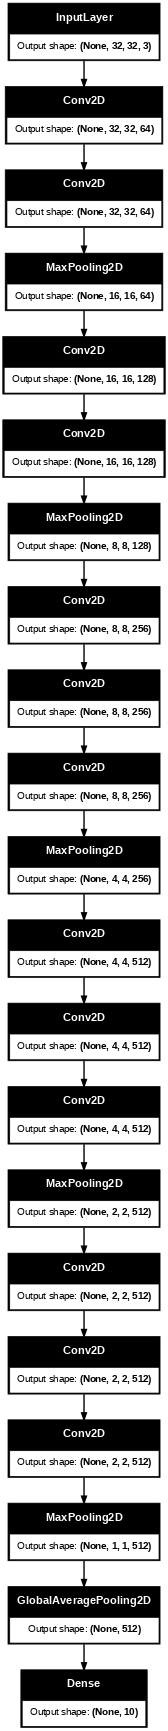

In [60]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [61]:
#Cambiamos el Optimizador
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.AdamW(learning_rate=1e-3)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [62]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 - 19s - 62ms/step - accuracy: 0.3891 - loss: 1.7893 - val_accuracy: 0.4853 - val_loss: 1.5376
Epoch 2/200
313/313 - 10s - 32ms/step - accuracy: 0.5075 - loss: 1.4619 - val_accuracy: 0.5189 - val_loss: 1.4136
Epoch 3/200
313/313 - 10s - 31ms/step - accuracy: 0.5346 - loss: 1.3723 - val_accuracy: 0.5375 - val_loss: 1.3556
Epoch 4/200
313/313 - 7s - 22ms/step - accuracy: 0.5516 - loss: 1.3222 - val_accuracy: 0.5481 - val_loss: 1.3198
Epoch 5/200
313/313 - 7s - 22ms/step - accuracy: 0.5625 - loss: 1.2882 - val_accuracy: 0.5561 - val_loss: 1.2950
Epoch 6/200
313/313 - 8s - 24ms/step - accuracy: 0.5702 - loss: 1.2631 - val_accuracy: 0.5617 - val_loss: 1.2768
Epoch 7/200
313/313 - 7s - 22ms/step - accuracy: 0.5763 - loss: 1.2436 - val_accuracy: 0.5663 - val_loss: 1.2627
Epoch 8/200
313/313 - 10s - 32ms/step - accuracy: 0.5812 - loss: 1.2277 - val_accuracy: 0.5707 - val_loss: 1.2516
Epoch 9/200
313/313 - 7s - 22ms/step - accuracy: 0.5854 - loss: 1.2145 - val_accuracy: 0.571

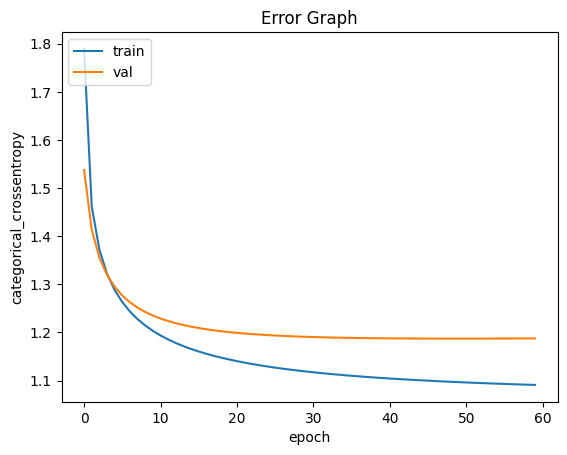

In [63]:
plot_losses(history, loss)

In [64]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.1918492317199707
Test accuracy: 0.5856999754905701


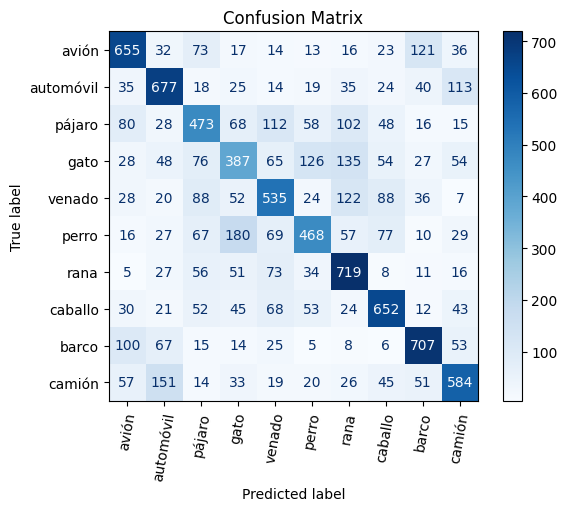

In [65]:
y_pred = model.predict(x_test, verbose = 0)

plot_cm(y_pred, y_test, LABELS_Cifar10, 80)

In [66]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=LABELS_Cifar10))

              precision    recall  f1-score   support

       avión       0.63      0.66      0.64      1000
   automóvil       0.62      0.68      0.65      1000
      pájaro       0.51      0.47      0.49      1000
        gato       0.44      0.39      0.41      1000
      venado       0.54      0.54      0.54      1000
       perro       0.57      0.47      0.51      1000
        rana       0.58      0.72      0.64      1000
     caballo       0.64      0.65      0.64      1000
       barco       0.69      0.71      0.70      1000
      camión       0.61      0.58      0.60      1000

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



Podemos observar que no obtenemos resultados tan buenos como la red anterior, pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Dataset Guiado

### 2.1 Exploracion de la Data

In [67]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/AlejandroVillazonG/Tareas_INF395/main/T1/Steel_industry_data.csv'
)
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [68]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

info = datainfo(df)
info.head()

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
date,object,35040,35040,0,0.0
Usage_kWh,float64,35040,3343,0,0.0
Lagging_Current_Reactive.Power_kVarh,float64,35040,1954,0,0.0
Leading_Current_Reactive_Power_kVarh,float64,35040,768,0,0.0
CO2(tCO2),float64,35040,8,0,0.0


In [69]:
print('Numeric variables:')
for i,variable in enumerate(df.select_dtypes(include = ['int64', 'float64']).columns):
    print(f'\t{i+1}. ({str(df[variable].dtype)}) {variable}')
print('\nCategoric variables:')
for i,variable in enumerate(df.select_dtypes(include = 'object').columns):
    print(f'\t{i+1}. {variable}')

Numeric variables:
	1. (float64) Usage_kWh
	2. (float64) Lagging_Current_Reactive.Power_kVarh
	3. (float64) Leading_Current_Reactive_Power_kVarh
	4. (float64) CO2(tCO2)
	5. (float64) Lagging_Current_Power_Factor
	6. (float64) Leading_Current_Power_Factor
	7. (int64) NSM

Categoric variables:
	1. date
	2. WeekStatus
	3. Day_of_week
	4. Load_Type


**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

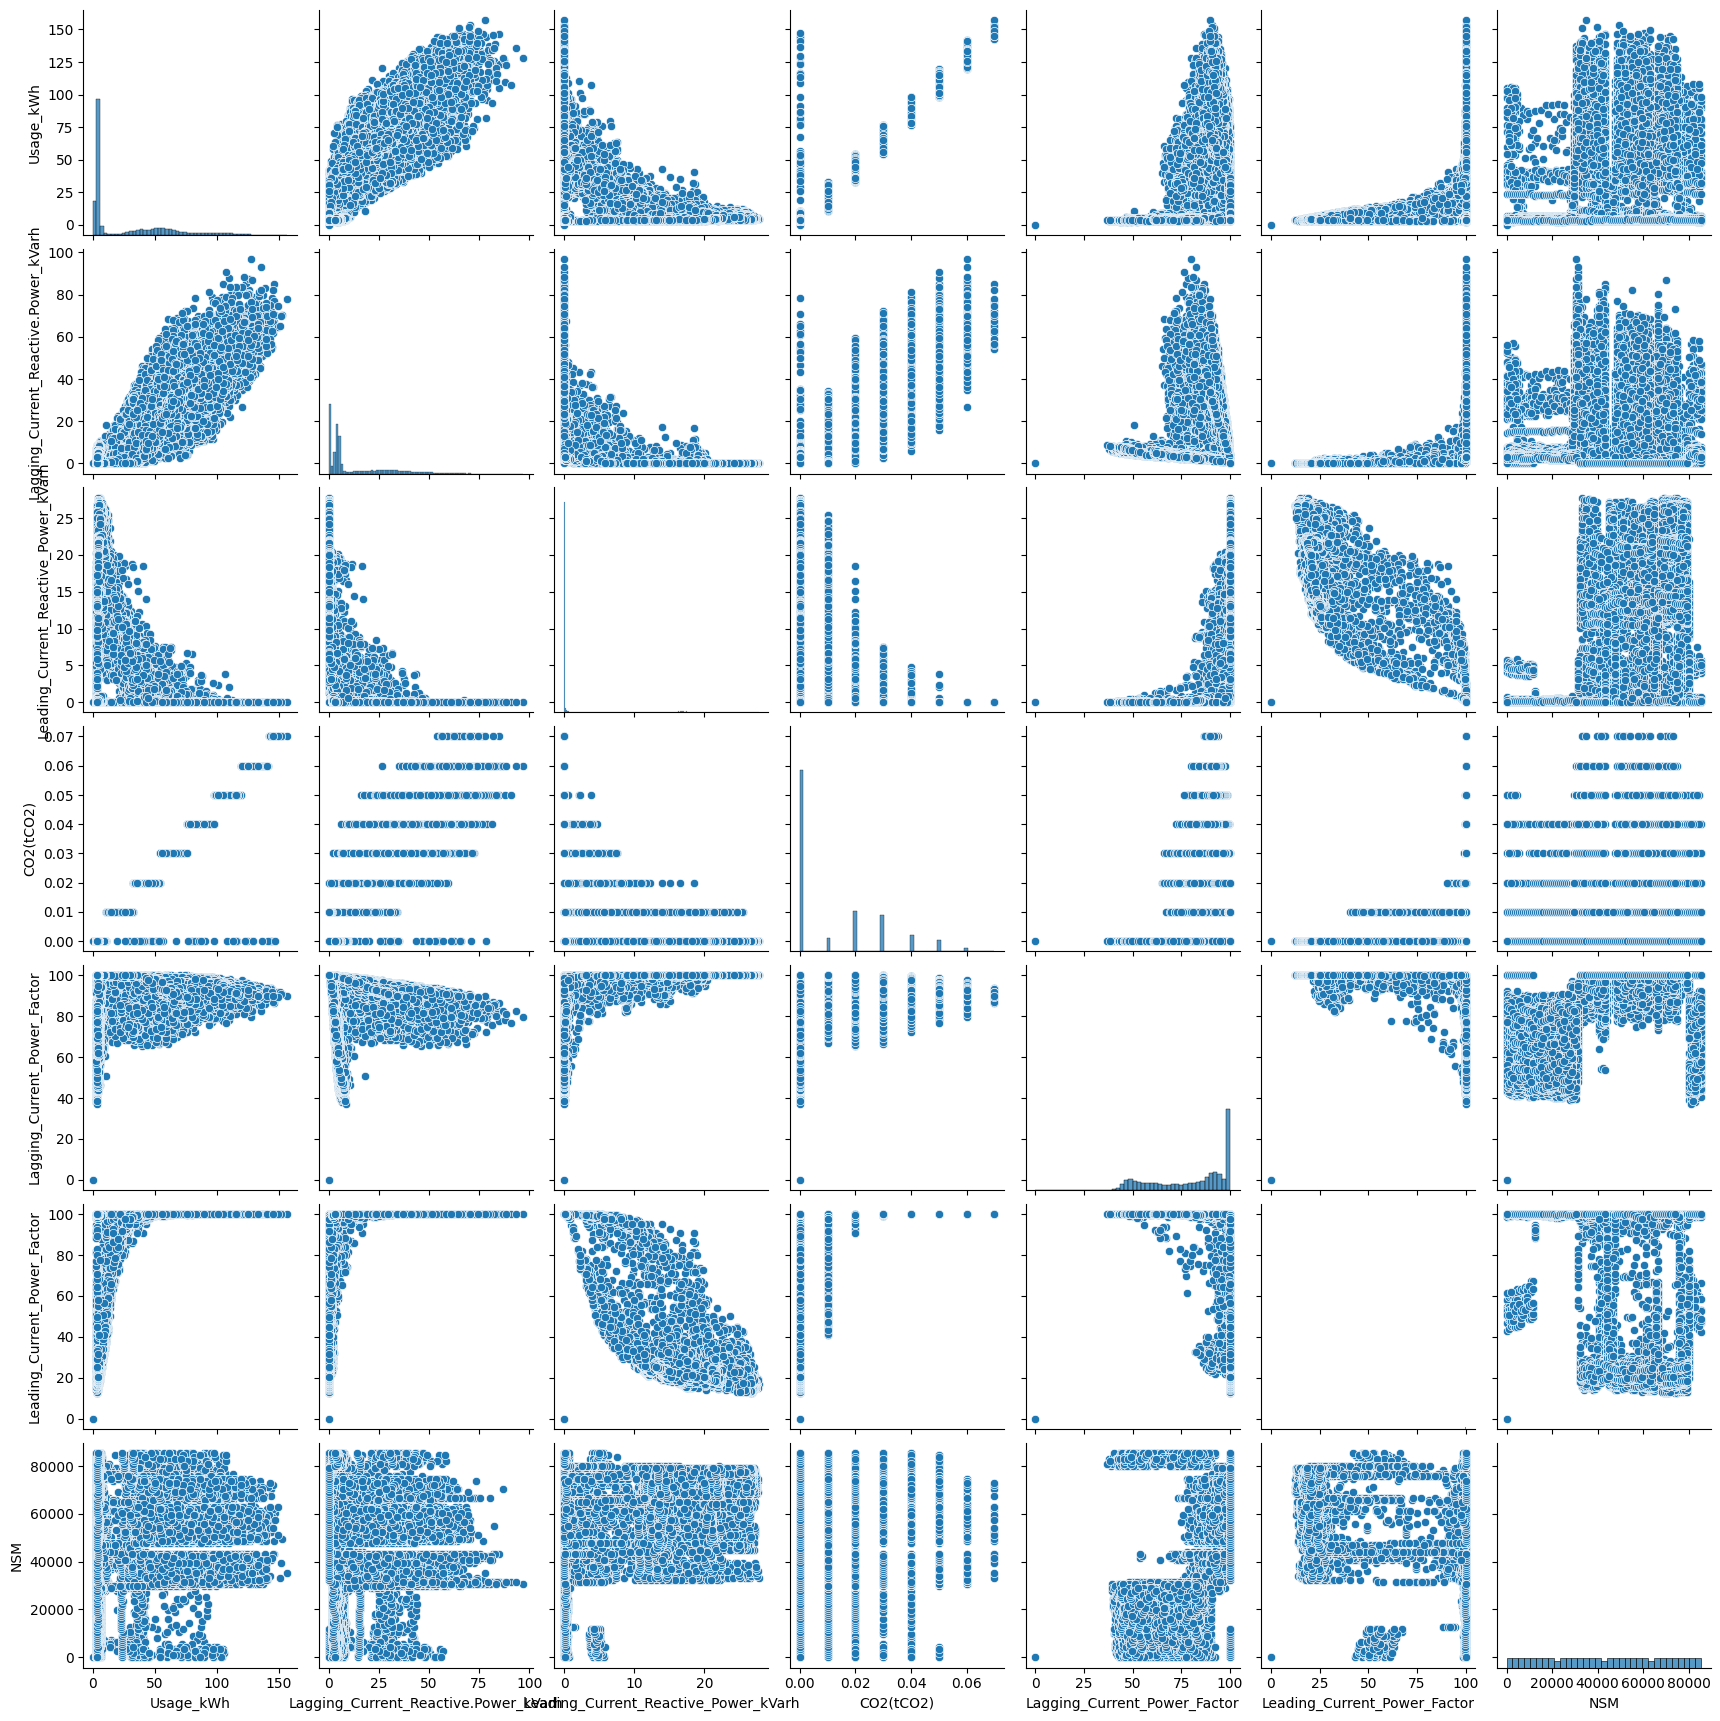

In [70]:
sns.pairplot(df);

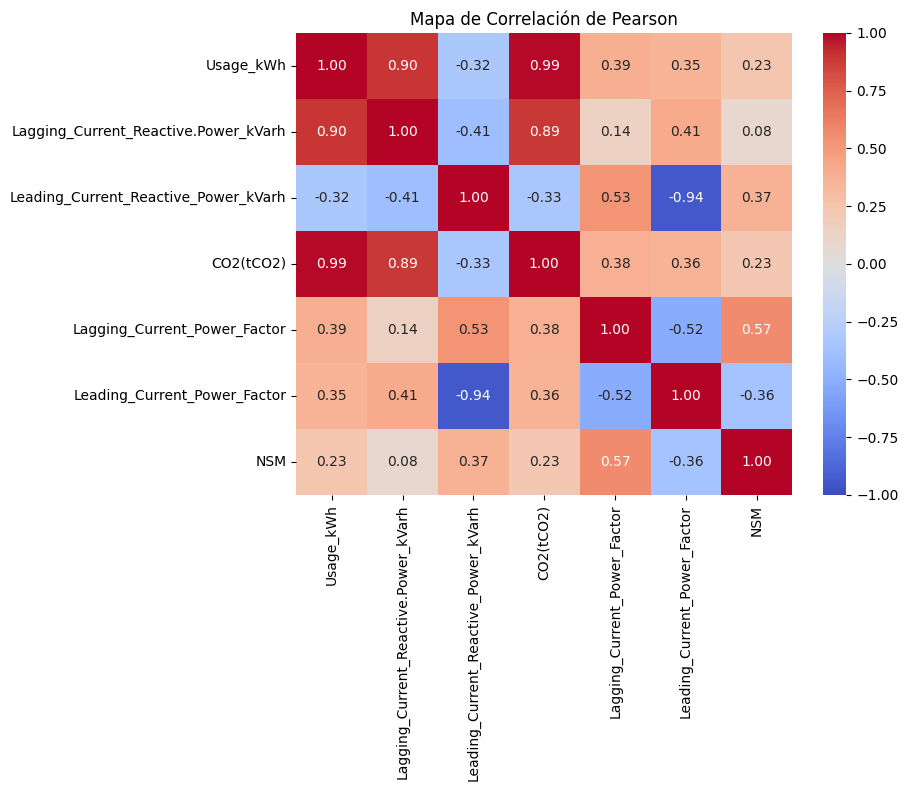

In [71]:
# Gráficos del EDA
# Calcular la matriz de correlación de Pearson
correlation_matrix = df.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Mapa de Correlación de Pearson')
plt.show()

Notamos una gran correlación entre nuestro target y las variables `CO2(tCO2)` y `Lagging_Current_Reactive.Power_kVarh`. Además, también hay alta correlación entre `Leading_Current_Reactive_Power_kVarh` con `Leading_Current_Power_Factor` y `CO2(tCO2)` con `Lagging_Current_Reactive.Power_kVarh`.

Para reducir la multicolinealidad en los datos (lo que es deseado pues esta puede hacer que el modelo sea más difícil de interpretar y puede llevar a resultados inestables) podríamos reducir variables, aplicar PCA, MI, etc. Dado que más adelante se nos pide un tratamiento con cada una de las variables, no aplicamos ninguna.

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

`Respuesta:`
*   `Training`: Se utiliza para ajustar los parámetros del modelo durante el proceso de entrenamiento. El modelo aprende a partir de estos datos y ajusta sus pesos y bias para minimizar el error en la predicción. Suele ser el conjunto más grande, ya que se necesita suficiente información para que el modelo aprenda patrones y relaciones en los datos.
*   `Validation`: Se utiliza para ajustar hiperparámetros y realizar una selección del modelo. Permite ajustar los parámetros que no son aprendidos durante el entrenamiento (como el learning rate) y evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento.
*   `Testing`: Se utiliza para evaluar el rendimiento final y realista del modelo en datos que no ha visto antes. Esto proporciona una estimación más precisa de cómo se comportará el modelo en situaciones del mundo real.

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [72]:
from sklearn.model_selection import train_test_split

# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Usage_kWh'], axis = 1), df['Usage_kWh'], test_size=0.1, random_state=SEED)

In [73]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

print('Cantidad de clases:', num_classes)
print('Dimensión de los datos:', input_shape)

Cantidad de clases: 3283
Dimensión de los datos: (10,)


In [74]:
X_train.tail()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
16850,25/06/2018 12:45,0.00,25.27,0.00,100.00,22.22,45900,Weekday,Monday,Medium_Load
6265,07/03/2018 06:30,4.57,0.00,0.00,63.03,100.00,23400,Weekday,Wednesday,Light_Load
11284,28/04/2018 13:15,0.14,14.33,0.01,99.99,68.76,47700,Weekend,Saturday,Maximum_Load
860,09/01/2018 23:15,4.32,0.00,0.00,73.19,100.00,83700,Weekday,Tuesday,Light_Load
15795,14/06/2018 13:00,0.00,20.05,0.00,100.00,31.69,46800,Weekday,Thursday,Medium_Load


### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

`Respuesta:` La utilidad es capturar y representar de manera efectiva la naturaleza cíclica de las variables relacionadas con fechas, como los días del año.

In [75]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [76]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,sin_day,cos_day
0,0.017213,0.999852
1,0.034422,0.999407
2,0.051620,0.998667
3,0.068802,0.997630
4,0.085965,0.996298


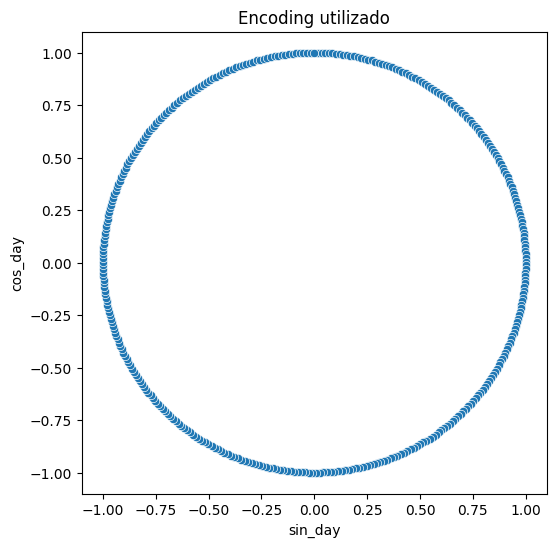

In [77]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(6, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado");

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]


`Respuesta:` Cada uno de los métodos se utiliza para codificar variables categóricas en un formato numérico para que puedan ser utilizadas por algoritmos de aprendizaje automático.

*   `One-Hot Encoding`: Convierte una variable categórica en varias columnas binarias (0 o 1), donde cada columna representa una categoría única en la variable original. Cada fila tendrá un 1 en la columna correspondiente a su categoría y 0 en las demás columnas.
*   `Ordinal Encoding`: Asigna un número entero a cada categoría única en una variable categórica de acuerdo con un orden específico predefinido. Se utiliza cuando las categorías tienen un orden intrínseco o jerarquía.
*   `Label Encoding`: Asigna un número entero único a cada categoría única en una variable categórica. No se considera un orden específico entre las categorías.

La diferencia entre One-Hot encoding y las otras transformaciones es que esta convierte la variable en varias columnas, aumentando la dimensionalidad de la data, mientras que las otras la mantienen, solo alteran el tipo de dato de la variable.

La diferencia entre Ordinal y Label encoding es que la primera considera un orden intrínseco en los valores, por lo que hay que ser cuidadoso al aplicarla.

---

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [78]:
# Revisemos los valores que toma 'Load_Type' para ser cuidadosos a la hora de hacer el encoding
X_train['Load_Type'].unique()

array(['Medium_Load', 'Light_Load', 'Maximum_Load'], dtype=object)

In [79]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

minmax_scaler = MinMaxScaler(feature_range=(0, 1))
standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=[['Light_Load', 'Medium_Load', 'Maximum_Load']])
onehot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

# Aplicar MinMaxScaler
X_train[['CO2(tCO2)', 'NSM']] = minmax_scaler.fit_transform(X_train[['CO2(tCO2)', 'NSM']])
X_test[['CO2(tCO2)', 'NSM']] = minmax_scaler.transform(X_test[['CO2(tCO2)', 'NSM']])

# Eliminamos dos de estas variables por evadir multicolinealidad
# Aplicar StandardScaler
X_train[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']] = standard_scaler.fit_transform(X_train[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                                                                                                     'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']])
X_test[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']] = standard_scaler.transform(X_test[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                                                                                                     'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']])


# Aplicar Ordinal Encoding
categorias = ['Light_Load', 'Medium_Load', 'Maximum_Load']
ordinal_encoder.fit_transform([[cat] for cat in categorias])
X_train['Load_Type'] = ordinal_encoder.transform(X_train['Load_Type'].values.reshape((-1,1)))
X_test['Load_Type'] = ordinal_encoder.transform(X_test['Load_Type'].values.reshape((-1,1)))

# Aplicar One-Hot Encoding
week_status_encoded = onehot_encoder.fit_transform(X_train[['WeekStatus']]).toarray()
week_status_columns = [f"WeekStatus_{status}" for status in onehot_encoder.categories_[0]]
X_train[week_status_columns] = week_status_encoded
X_train = X_train.drop(['WeekStatus'], axis = 1)

week_status_encoded = onehot_encoder.transform(X_test[['WeekStatus']]).toarray()
week_status_columns = [f"WeekStatus_{status}" for status in onehot_encoder.categories_[0]]
X_test[week_status_columns] = week_status_encoded
X_test = X_test.drop(['WeekStatus'], axis = 1)

# Aplicar Label Encoding
# Hacemos la observación de que esta variable podría tratarse como cíclica, pero no es lo que se pide.
X_train['Day_of_week'] = label_encoder.fit_transform(X_train['Day_of_week'])
X_test['Day_of_week'] = label_encoder.transform(X_test['Day_of_week'])

In [80]:
X_train.tail()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend
16850,25/06/2018 12:45,-0.799577,2.879447,0.000000,1.025560,-2.039684,0.536842,1,1.0,1.0,0.0
6265,07/03/2018 06:30,-0.519133,-0.522085,0.000000,-0.930234,0.513479,0.273684,6,0.0,1.0,0.0
11284,28/04/2018 13:15,-0.790985,1.406841,0.142857,1.025031,-0.511988,0.557895,2,2.0,0.0,1.0
860,09/01/2018 23:15,-0.534475,-0.522085,0.000000,-0.392748,0.513479,0.978947,5,0.0,1.0,0.0
15795,14/06/2018 13:00,-0.799577,2.176796,0.000000,1.025560,-1.728827,0.547368,4,1.0,1.0,0.0


In [81]:
X_train[['dia', 'hora']] = X_train['date'].str.split(' ', expand = True)
X_train[['dia', 'mes', 'año']] = X_train['dia'].str.split('/', expand = True).astype(int)
X_train['hora'] =  X_train['hora'].str.split(':', expand = True)[0].astype(int)

X_test[['dia', 'hora']] = X_test['date'].str.split(' ', expand = True)
X_test[['dia', 'mes', 'año']] = X_test['dia'].str.split('/', expand = True).astype(int)
X_test['hora'] =  X_test['hora'].str.split(':', expand = True)[0].astype(int)

In [82]:
X_train.head()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,dia,hora,mes,año
14833,04/06/2018 12:30,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,1.0,1.0,0.0,4,12,6,2018
7974,25/03/2018 01:45,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,25,1,3,2018
25807,26/09/2018 20:00,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,26,20,9,2018
5987,04/03/2018 09:00,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,4,9,3,2018
15757,14/06/2018 03:30,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,14,3,6,2018


Notemos las observaciones fueron tomadas un mismo año, por lo que esta variable no nos aportará información en el entrenamiento.

In [83]:
print(X_train['año'].unique())
print(X_test['año'].unique())

[2018]
[2018]


In [84]:
X_train = X_train.drop(['año', 'date'], axis = 1)
X_test = X_test.drop(['año', 'date'], axis = 1)

In [85]:
X_train.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,dia,hora,mes
14833,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,1.0,1.0,0.0,4,12,6
7974,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,25,1,3
25807,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,26,20,9
5987,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,4,9,3
15757,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,14,3,6


In [86]:
X_train = preprocess_time(X_train, "dia", 30)
X_test = preprocess_time(X_test, "dia", 30)

X_train = preprocess_time(X_train, "mes", 12)
X_test = preprocess_time(X_test, "mes", 12)

X_train = preprocess_time(X_train, "hora", 24)
X_test = preprocess_time(X_test, "hora", 24)

In [87]:
X_train.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,sin_dia,cos_dia,sin_mes,cos_mes,sin_hora,cos_hora
14833,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,1.0,1.0,0.0,0.743145,0.669131,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000
7974,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,-0.866025,0.500000,1.000000e+00,6.123234e-17,2.588190e-01,0.965926
25807,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,-0.743145,0.669131,-1.000000e+00,-1.836970e-16,-8.660254e-01,0.500000
5987,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,0.743145,0.669131,1.000000e+00,6.123234e-17,7.071068e-01,-0.707107
15757,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,0.207912,-0.978148,1.224647e-16,-1.000000e+00,7.071068e-01,0.707107


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

`Obs:` Fueron separados anteriormente.

In [88]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
#y_train = '''TODO'''
#X_train = '''TODO'''

#y_test = '''TODO'''
#X_test = '''TODO'''

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, acá queda a libre elección si quieren utilizar la API secuencial o funcional, y también queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [89]:
print(f'Training:\n {min(y_train) = }\n {max(y_train) = }')

Training:
 min(y_train) = 0.0
 max(y_train) = 157.18


In [90]:
#Crear un modelo de Keras a libre elección

inputs = keras.layers.Input(shape=(X_train.shape[1:]))
x =  keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 128)               │      2,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_18 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: La capa de salida debe tener solo una neurona. Para el problema de regresión lo usual es que la función de activación de la capa de salida sea lineal, sin embargo, como la variable a predecir solo toma valores positivos, proponemos una función de activación ReLU.

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [91]:
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [92]:
epochs = 200
batch_size = 128
val_split = 0.1
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

### 2.6 Entrenando el Modelo

In [93]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=2)

Epoch 1/200
222/222 - 3s - 14ms/step - loss: 948.3171 - mean_absolute_error: 18.5257 - mean_squared_error: 949.0646 - root_mean_squared_error: 30.8069 - val_loss: 263.2570 - val_mean_absolute_error: 10.4978 - val_mean_squared_error: 261.1519 - val_root_mean_squared_error: 16.1602
Epoch 2/200
222/222 - 1s - 2ms/step - loss: 133.8013 - mean_absolute_error: 7.6017 - mean_squared_error: 133.8655 - root_mean_squared_error: 11.5700 - val_loss: 79.9018 - val_mean_absolute_error: 6.2302 - val_mean_squared_error: 79.5139 - val_root_mean_squared_error: 8.9171
Epoch 3/200
222/222 - 1s - 2ms/step - loss: 62.4329 - mean_absolute_error: 5.7005 - mean_squared_error: 62.4569 - root_mean_squared_error: 7.9030 - val_loss: 50.1863 - val_mean_absolute_error: 5.2604 - val_mean_squared_error: 50.0068 - val_root_mean_squared_error: 7.0715
Epoch 4/200
222/222 - 1s - 2ms/step - loss: 42.5351 - mean_absolute_error: 4.8964 - mean_squared_error: 42.5518 - root_mean_squared_error: 6.5232 - val_loss: 35.1157 - val_

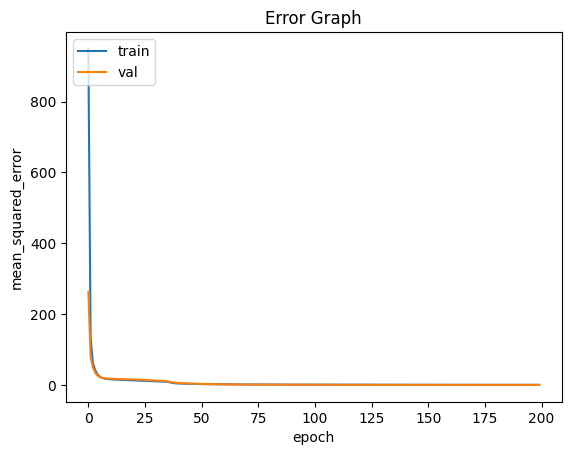

In [94]:
plot_losses(history, loss)

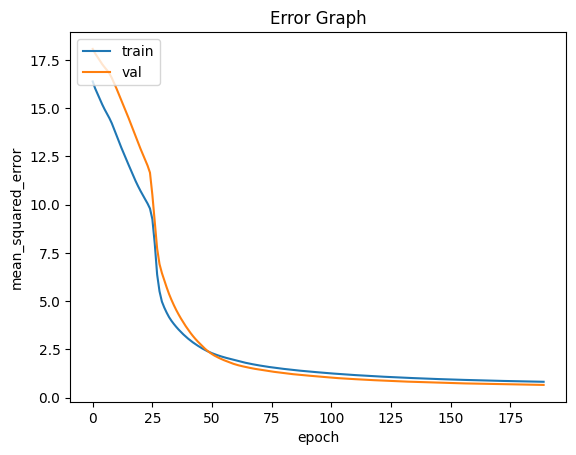

In [95]:
# Realizamos el mismo gráfico pero quitando la información de las primeras 10 epochs
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Error Graph')
plt.ylabel(loss.name)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

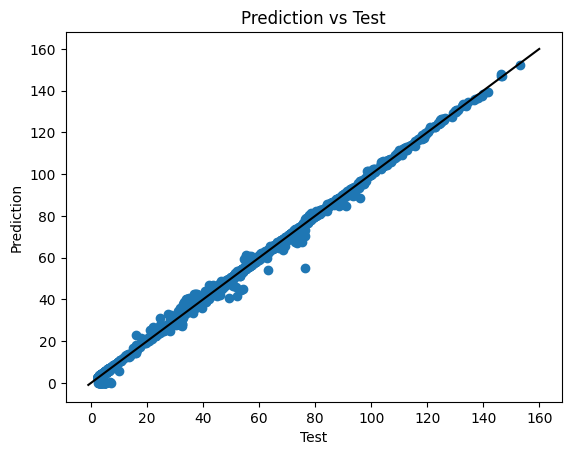

In [96]:
y_pred = model.predict(X_test, verbose = 0)

plt.scatter(y_test, y_pred)
plt.plot([-1,160], [-1,160], c='black')

plt.xlabel('Test')
plt.ylabel('Prediction')
plt.title('Prediction vs Test')

plt.show()

In [97]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test mean_squared_error:", score[1])
print("Test mean_absolute_error:", score[2])
print("Test root_mean_squared_error:", score[3])

Test loss: 1.0872312784194946
Test mean_squared_error: 0.4377957284450531
Test mean_absolute_error: 1.0874032974243164
Test root_mean_squared_error: 1.0427863597869873


In [98]:
print(f'Test:\n {min(y_test) = }\n {max(y_test) = }')

Test:
 min(y_test) = 2.45
 max(y_test) = 153.14


Notando que la diferencia máxima de los datos es aproximadamente 150, aseguramos que el error posee un orden de magnitud muy inferior al de los datos, por lo que nuestra predicción es bastante cercana, como se evidencia en el gráfico comparativo.

### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [99]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.

In [100]:
modelo_cargado = keras.models.load_model('steel_ind_regression.keras')

In [101]:
model.get_weights()[-1]

array([0.2044627], dtype=float32)

In [102]:
modelo_cargado.get_weights()[-1]

array([0.2044627], dtype=float32)

In [103]:
y_predd = modelo_cargado.predict(X_test, verbose = 0)
y_predd

array([[  2.7546604 ],
       [ 60.527294  ],
       [120.852455  ],
       ...,
       [  0.47468346],
       [ 80.590515  ],
       [  3.170305  ]], dtype=float32)

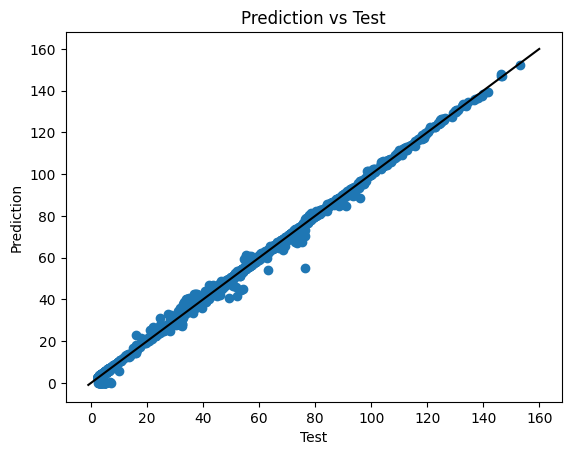

In [104]:
y_pred = modelo_cargado.predict(X_test, verbose = 0)

plt.scatter(y_test, y_pred)
plt.plot([-1,160], [-1,160], c='black')

plt.xlabel('Test')
plt.ylabel('Prediction')
plt.title('Prediction vs Test')

plt.show()

In [105]:
score = modelo_cargado.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test mean_squared_error:", score[1])
print("Test mean_absolute_error:", score[2])
print("Test root_mean_squared_error:", score[3])

Test loss: 1.0872312784194946
Test mean_squared_error: 0.4377957284450531
Test mean_absolute_error: 1.0874032974243164
Test root_mean_squared_error: 1.0427863597869873
